<a href="https://colab.research.google.com/github/TrudeauOkech/TitanicPrediction/blob/main/TitanicPediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

In [30]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from lime import lime_tabular
import warnings
warnings.filterwarnings("ignore")

In [20]:
dtf = pd.read_csv('data_titanic.csv')
dtf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
#This function is used to further recognize the type of data in the columns and didtinguish them between "numerical" and "categorical" data. 
#This is important in order iot summarize the main characteristics of a dataset(making it easier to work on and undestand)
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

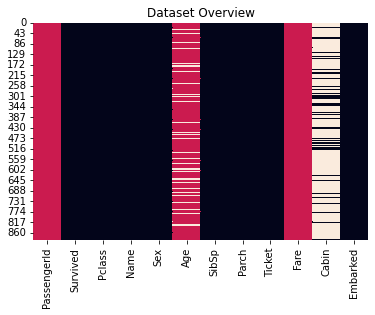

 Categerocial   Numeric   NaN 


In [22]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [23]:
dtf = dtf.set_index("PassengerId")
dtf = dtf.rename(columns={"Survived":"Y"})

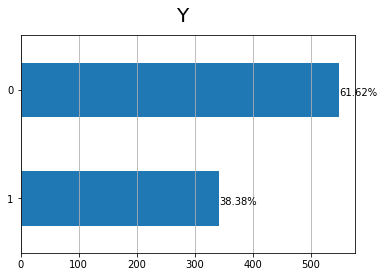

In [24]:
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

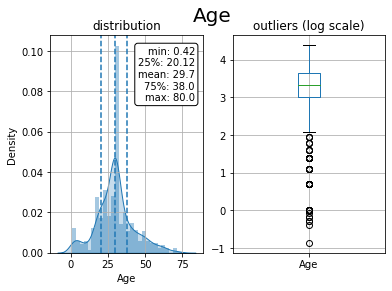

In [25]:
x = "Age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

Text(0.5, 1.0, 'Cabin_section vs Pclass (filter: Y)')

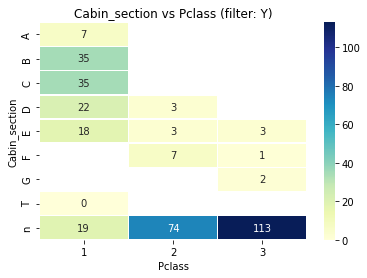

In [32]:
## Create new column
dtf["Cabin_section"] = dtf["Cabin"].apply(lambda x: str(x)[0])
## Plot contingency table
cont_table = pd.crosstab(index=dtf["Cabin_section"], 
             columns=dtf["Pclass"], values=dtf["Y"], aggfunc="sum")
sns.heatmap(cont_table, annot=True, cmap="YlGnBu", fmt='.0f',
            linewidths=.5).set_title( 
            'Cabin_section vs Pclass (filter: Y)' )

In [33]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (623, 11) | X_test shape: (268, 11)
y_train mean: 0.41 | y_test mean: 0.33
12 features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_section']


In [34]:
dtf_train["Age"] = dtf_train["Age"].fillna(dtf_train["Age"].mean())

In [35]:
## create dummy
dummy = pd.get_dummies(dtf_train["Sex"], 
                       prefix="Sex",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Sex", axis=1).head() )
## drop the original categorical column
dtf = dtf_train.drop("Sex", axis=1)

                Sex  Sex_male
PassengerId                  
158            male         1
738            male         1
872          female         0
841            male         1
269          female         0


In [37]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
dtf_scaled["Y"] = dtf_train["Y"]
dtf_scaled.head()

ValueError: ignored